In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


Mounted at /content/drive


In [ ]:
import torch
from torch import nn

def t2v(tau, f, out_features, w, b, w0, b0, arg=None):
    """
    tau: (batch, in_features)
    f: função periódica (torch.sin ou torch.cos)
    out_features: dimensão de saída (k)
    w: pesos periódicos (in_features, k-1)
    b: bias periódicos (k-1,)
    w0: peso linear (in_features, 1)
    b0: bias linear (1,)
    """
    if arg is not None:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    return torch.cat([v1, v2], dim=-1)  # (batch, k)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.Parameter(torch.randn(1))
        self.w = nn.Parameter(torch.randn(in_features, out_features - 1))
        self.b = nn.Parameter(torch.randn(out_features - 1))
        self.f = torch.sin

    def forward(self, tau):
        # tau: (batch, in_features)
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class CosineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(CosineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.Parameter(torch.randn(1))
        self.w = nn.Parameter(torch.randn(in_features, out_features - 1))
        self.b = nn.Parameter(torch.randn(out_features - 1))
        self.f = torch.cos

    def forward(self, tau):
        # tau: (batch, in_features)
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)


In [ ]:
import pandas as pd
import numpy as np

ESTADO = "north carolina"

CHECKINS_PATH = f"/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv"

checkins = pd.read_csv(CHECKINS_PATH)

cols_necessarias = ["local_datetime", "category", "placeid"]
for c in cols_necessarias:
    if c not in checkins.columns:
        raise ValueError(f"Coluna obrigatória ausente: {c}")

print("Tipos originais:")
print(checkins[cols_necessarias].dtypes)

print("Exemplo de linhas:")
display(checkins[cols_necessarias].head())
print("N checkins (antes de filtrar):", len(checkins))

checkins["local_datetime"] = pd.to_datetime(
    checkins["local_datetime"].astype(str),
    utc=True,
    errors="coerce"
)

print("\nDepois do to_datetime:")
print(checkins["local_datetime"].dtype)

checkins = checkins.dropna(subset=["local_datetime"]).reset_index(drop=True)
print("N checkins (após remover inválidos):", len(checkins))

dt = checkins["local_datetime"]

hour = dt.dt.hour + dt.dt.minute / 60.0
dow  = dt.dt.weekday


t1 = (hour / 24.0).astype(np.float32)
t2 = (dow  / 7.0).astype(np.float32)
times = np.stack([t1, t2], axis=1).astype(np.float32)

categories = checkins[["category"]].astype(str).values
placeids   = checkins[["placeid"]].astype(str).values

print("\nExemplo hour/dow:")
print(hour.head(), dow.head())
print("times shape:", times.shape)

Tipos originais:
local_datetime    object
category          object
placeid            int64
dtype: object
Exemplo de linhas:


,local_datetime,category,placeid
0,2010-03-07 00:49:25+00:00,Travel,18643
1,2010-08-11 01:22:30+00:00,Travel,18643
2,2010-10-09 19:23:04+00:00,Travel,18643
3,2010-09-26 14:28:01+00:00,Travel,18643
4,2010-04-01 18:57:23+00:00,Travel,18643


N checkins (antes de filtrar): 229247

Depois do to_datetime:
datetime64[ns, UTC]
N checkins (após remover inválidos): 229247

Exemplo hour/dow:
0     0.816667
1     1.366667
2    19.383333
3    14.466667
4    18.950000
Name: local_datetime, dtype: float64 0    6
1    2
2    5
3    6
4    3
Name: local_datetime, dtype: int32
times shape: (229247, 2)


In [ ]:
dt = checkins["local_datetime"]

t0 = dt.min()
time_hours = (dt - t0).dt.total_seconds() / 3600.0

hour = dt.dt.hour + dt.dt.minute / 60.0
dow  = dt.dt.weekday

t_hour = (hour / 24.0).astype(np.float32)
t_dow  = (dow  / 7.0).astype(np.float32)

time_feats = np.stack([t_hour, t_dow], axis=1).astype(np.float32)

print(time_hours.shape, time_feats.shape)



(229247,) (229247, 2)


In [ ]:
checkins["local_datetime"].head()

,local_datetime
0,2010-03-07 00:49:25+00:00
1,2010-08-11 01:22:30+00:00
2,2010-10-09 19:23:04+00:00
3,2010-09-26 14:28:01+00:00
4,2010-04-01 18:57:23+00:00


In [ ]:
class TemporalContrastiveDataset(Dataset):
    def __init__(
        self,
        time_hours,
        time_feats,
        r_pos_hours=1.0,
        r_neg_hours=24.0,
        max_pairs=50_000,
        k_neg_per_i=5,
        max_pos_per_i=20,
        seed=42,
    ):
        super().__init__()
        self.times = np.asarray(time_hours, dtype=np.float32)
        self.feats = np.asarray(time_feats, dtype=np.float32)
        self.N = len(self.times)
        self.r_pos = float(r_pos_hours)
        self.r_neg = float(r_neg_hours)
        self.rng = np.random.default_rng(seed)

        order = np.argsort(self.times)
        times_sorted = self.times[order]

        pairs_i = []
        pairs_j = []
        labels = []

        approx_pairs_per_i = (max_pos_per_i or 1) + k_neg_per_i
        max_i = min(self.N, max_pairs // max(1, approx_pairs_per_i) + 1)

        chosen_sorted_idx = self.rng.choice(self.N, size=max_i, replace=False)

        for idx_s in chosen_sorted_idx:
            if len(pairs_i) >= max_pairs:
                break

            i = int(order[idx_s])
            t_i = times_sorted[idx_s]

            left = np.searchsorted(times_sorted, t_i - self.r_pos, side="left")
            right = np.searchsorted(times_sorted, t_i + self.r_pos, side="right")
            cand_sorted = np.arange(left, right)
            cand_sorted = cand_sorted[cand_sorted != idx_s]

            if cand_sorted.size > 0:
                if max_pos_per_i is not None and cand_sorted.size > max_pos_per_i:
                    cand_sorted = self.rng.choice(
                        cand_sorted, size=max_pos_per_i, replace=False
                    )
                for s_j in cand_sorted:
                    j = int(order[s_j])
                    pairs_i.append(i)
                    pairs_j.append(j)
                    labels.append(1)
                    if len(pairs_i) >= max_pairs:
                        break

            if len(pairs_i) >= max_pairs:
                break

            got = 0
            trials = 0
            max_trials = 50 * k_neg_per_i
            while got < k_neg_per_i and trials < max_trials and len(pairs_i) < max_pairs:
                j = int(self.rng.integers(0, self.N))
                trials += 1
                if j == i:
                    continue
                if abs(self.times[j] - t_i) < self.r_neg:
                    continue
                pairs_i.append(i)
                pairs_j.append(j)
                labels.append(0)
                got += 1

        self.pairs = list(zip(pairs_i, pairs_j, labels))
        print(f"Total de pares gerados: {len(self.pairs)}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        feat_i = self.feats[i]
        feat_j = self.feats[j]
        return feat_i, feat_j, label


In [ ]:
R_POS_HOURS = 1.0
R_NEG_HOURS = 24.0
MAX_PAIRS   = 2_000_000

dataset = TemporalContrastiveDataset(
    time_hours=time_hours,
    time_feats=time_feats,
    r_pos_hours=R_POS_HOURS,
    r_neg_hours=R_NEG_HOURS,
    max_pairs=MAX_PAIRS,
    k_neg_per_i=5,
    max_pos_per_i=20,
)

loader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
)

len(dataset)


Total de pares gerados: 1930192


1930192

In [ ]:
class Time2VecPeriodicContrastiveModel(nn.Module):
    def __init__(self, activation="sin", out_features=64, embed_dim=64):
        """
        activation: "sin" ou "cos"
        out_features: dimensão
        embed_dim: dimensão do embedding
        """
        super().__init__()
        self.activation_name = activation

        if activation == "sin":
            self.time_layer = SineActivation(in_features=2, out_features=out_features)
        elif activation == "cos":
            self.time_layer = CosineActivation(in_features=2, out_features=out_features)
        else:
            raise ValueError("activation deve ser 'sin' ou 'cos'")

        self.projector = nn.Linear(out_features, embed_dim)

    def encode(self, t):
        """
        t: tensor (batch,) ou (batch,1) com times em horas
        retorna: embeddings normalizados (batch, embed_dim)
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)


        t2v = self.time_layer(t)
        z = self.projector(t2v)
        z = F.normalize(z, dim=-1)
        return z

    def forward(self, t_i, t_j):
        """
        t_i, t_j: batch de tempos (batch,)
        retorna embeddings para i e j
        """
        z_i = self.encode(t_i)
        z_j = self.encode(t_j)
        return z_i, z_j

    def contrastive_loss(self, z_i, z_j, label, tau=0.3):
        sim = F.cosine_similarity(z_i, z_j)   # (B,)
        logits = sim / tau
        targets = label.float()
        return F.binary_cross_entropy_with_logits(logits, targets)



In [ ]:

def treinar_time2vec_periodic(
    activation="sin",
    out_features=64,
    embed_dim=64,
    n_epochs=100,
    lr=1e-3,
    dataloader=None,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device, "| Activation:", activation)

    model = Time2VecPeriodicContrastiveModel(
        activation=activation,
        out_features=out_features,
        embed_dim=embed_dim,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0.0

        for t_i, t_j, label in dataloader:
            t_i = t_i.to(device=device, dtype=torch.float32)
            t_j = t_j.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.float32)

            z_i, z_j = model(t_i, t_j)
            loss = model.contrastive_loss(z_i, z_j, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"[{activation}] Epoch {epoch:03d}/{n_epochs}: loss = {avg_loss:.4f}")

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_sin = treinar_time2vec_periodic(
    activation="sin",
    out_features=64,
    embed_dim=128,
    n_epochs=100,
    lr=1e-3,
    dataloader=loader,
    device=device,
)

Device: cpu | Activation: sin
[sin] Epoch 001/100: loss = 0.2379
[sin] Epoch 002/100: loss = 0.2260
[sin] Epoch 003/100: loss = 0.2204
[sin] Epoch 004/100: loss = 0.2186
[sin] Epoch 005/100: loss = 0.2171
[sin] Epoch 006/100: loss = 0.2142
[sin] Epoch 007/100: loss = 0.2115
[sin] Epoch 008/100: loss = 0.2109
[sin] Epoch 009/100: loss = 0.2106
[sin] Epoch 010/100: loss = 0.2103
[sin] Epoch 011/100: loss = 0.2100
[sin] Epoch 012/100: loss = 0.2095
[sin] Epoch 013/100: loss = 0.2090
[sin] Epoch 014/100: loss = 0.2082
[sin] Epoch 015/100: loss = 0.2074
[sin] Epoch 016/100: loss = 0.2068
[sin] Epoch 017/100: loss = 0.2063
[sin] Epoch 018/100: loss = 0.2058
[sin] Epoch 019/100: loss = 0.2054
[sin] Epoch 020/100: loss = 0.2048
[sin] Epoch 021/100: loss = 0.2045
[sin] Epoch 022/100: loss = 0.2041
[sin] Epoch 023/100: loss = 0.2039
[sin] Epoch 024/100: loss = 0.2037
[sin] Epoch 025/100: loss = 0.2035
[sin] Epoch 026/100: loss = 0.2033
[sin] Epoch 027/100: loss = 0.2032
[sin] Epoch 028/100: loss

Device do modelo: cpu


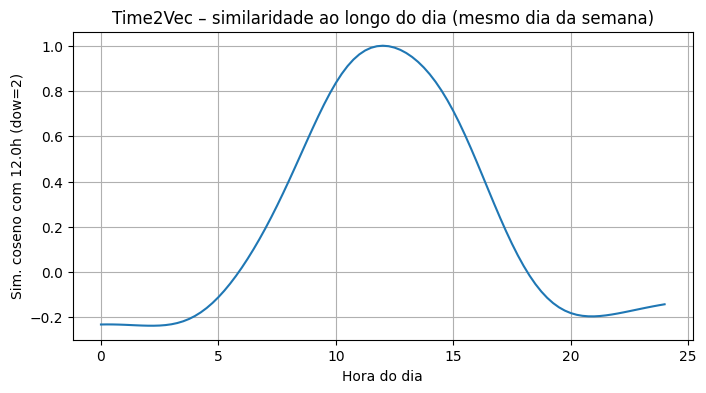

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model = model_sin
model.eval()

device = next(model.parameters()).device
print("Device do modelo:", device)

def encode_time(hour_float, dow=0):
    """
    hour_float: hora em [0, 24)
    dow: dia da semana [0..6]
    retorna embedding normalizado
    """
    t_hour_norm = hour_float / 24.0
    t_dow_norm  = dow / 6.0

    t = torch.tensor([[t_dow_norm, t_hour_norm]],
                     dtype=torch.float32,
                     device=device)
    with torch.no_grad():
        z = model.encode(t)
    return z

hours = np.linspace(0.0, 24.0, 97)

ref_hour = 12.0
ref_dow  = 2

z_ref = encode_time(ref_hour, ref_dow)

sims = []
for h in hours:
    z_h = encode_time(h, ref_dow)
    sim = F.cosine_similarity(z_ref, z_h).item()
    sims.append(sim)

plt.figure(figsize=(8, 4))
plt.plot(hours, sims)
plt.xlabel("Hora do dia")
plt.ylabel(f"Sim. coseno com {ref_hour}h (dow={ref_dow})")
plt.title("Time2Vec – similaridade ao longo do dia (mesmo dia da semana)")
plt.grid(True)
plt.show()


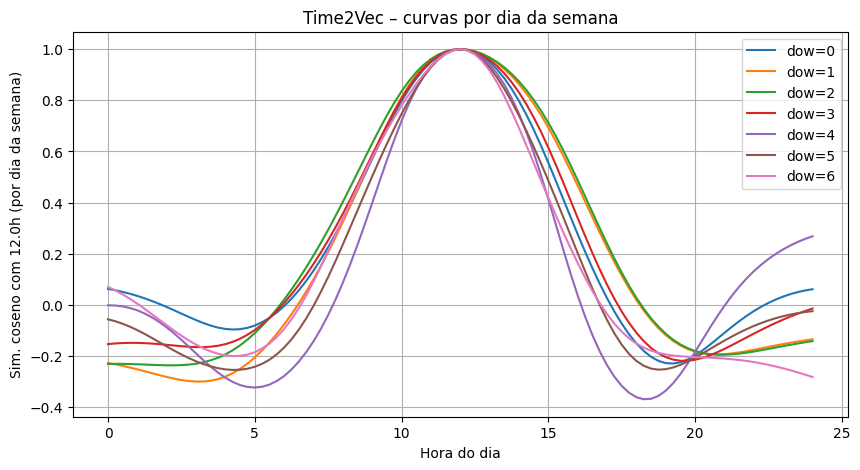

In [ ]:
plt.figure(figsize=(10, 5))

hours = np.linspace(0.0, 24.0, 97)
ref_hour = 12.0

for dow in range(7):
    z_ref = encode_time(ref_hour, dow)
    sims = []
    for h in hours:
        z_h = encode_time(h, dow)
        sim = F.cosine_similarity(z_ref, z_h).item()
        sims.append(sim)

    plt.plot(hours, sims, label=f"dow={dow}")

plt.xlabel("Hora do dia")
plt.ylabel(f"Sim. coseno com {ref_hour}h (por dia da semana)")
plt.title("Time2Vec – curvas por dia da semana")
plt.grid(True)
plt.legend()
plt.show()


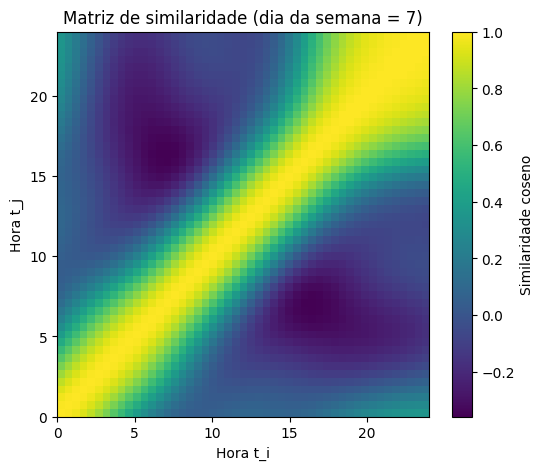

In [ ]:
hours = np.linspace(0.0, 24.0, 49)
dow = 7

Z = []
with torch.no_grad():
    embeds = []
    for h in hours:
        embeds.append(encode_time(h, dow))
    embeds = torch.cat(embeds, dim=0)

    sims = F.cosine_similarity(
        embeds.unsqueeze(1),
        embeds.unsqueeze(0),
        dim=-1
    ).cpu().numpy()

plt.figure(figsize=(6, 5))
plt.imshow(sims, origin="lower", extent=[0, 24, 0, 24], aspect="auto")
plt.colorbar(label="Similaridade coseno")
plt.xlabel("Hora t_i")
plt.ylabel("Hora t_j")
plt.title(f"Matriz de similaridade (dia da semana = {dow})")
plt.show()


In [ ]:
model_sin.eval()
with torch.no_grad():
    t_tensor = torch.from_numpy(times).to(device)
    time_embeds_sin = model_sin.encode(t_tensor).cpu().numpy()

print("time_embeds_sin shape:", time_embeds_sin.shape)


time_embeds_sin shape: (229247, 128)


In [ ]:
n_embeds = time_embeds_sin.shape[1]
embed_cols = [str(i) for i in range(n_embeds)]

df_time_sin = pd.DataFrame(
    np.hstack([placeids, time_embeds_sin, categories]),
    columns=["placeid"] + embed_cols + ["category"],
)

df_time_sin["placeid"] = df_time_sin["placeid"].astype(str)
df_time_sin["category"] = df_time_sin["category"].astype(str)
for c in embed_cols:
    df_time_sin[c] = df_time_sin[c].astype(np.float32)

out_path_sin_checkin = f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/time_encoder_embeddings_sin_checkin_{ESTADO}.csv"
df_time_sin.to_csv(out_path_sin_checkin, index=False)

df_time_sin.head()


,placeid,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,category
0,18643,-0.067986,-0.070390,-0.086468,0.097119,0.121310,-0.173489,0.123069,-0.106021,0.091764,...,0.063731,-0.106329,-0.041538,0.156565,0.087423,0.007450,-0.013204,-0.088996,-0.075239,Travel
1,18643,-0.028520,0.055628,0.028691,-0.134620,0.089171,0.067246,0.036371,-0.099359,-0.153268,...,0.099805,0.001997,-0.041719,0.060378,0.058123,-0.089724,0.008985,-0.037938,-0.015481,Travel
2,18643,0.074607,0.103950,0.075797,0.043804,-0.113280,-0.020200,-0.063383,0.208469,-0.100209,...,0.025670,0.087029,0.069733,-0.043313,0.005075,-0.045843,-0.043929,0.087359,-0.030947,Travel
3,18643,-0.129749,-0.093108,-0.004096,-0.175049,-0.029719,0.142422,0.133141,0.000549,0.046529,...,0.001294,0.023163,-0.030639,-0.113928,0.010267,0.011795,-0.077216,-0.035955,0.020477,Travel
4,18643,0.025015,0.033719,0.066555,-0.037960,-0.102750,0.086280,0.085532,-0.103531,0.012126,...,-0.052108,0.030904,0.014727,-0.015082,-0.333476,0.030265,0.052830,0.040816,0.028438,Travel


In [ ]:
out_path_sin_checkin

'/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/time_encoder_embeddings_sin_checkin_california.csv'